In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from computational_utils import l2_norm

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
})

In [3]:
setup = {
    'interval': (-1, 1),
    'spring_len': 1,
    'material_const': (1, 1),
    'spring_const': (1, 1),
    'body_forces': lambda x: np.where(x < 0, 1, -1)
}

In [4]:
def approximate_in_positions(
        values: np.ndarray,
        reference_nodes: np.ndarray,
        nodes: np.ndarray
):
    assert reference_nodes.size == values.size
    result = np.empty_like(nodes)
    result[0] = result[-1] = 0
    ref_idx = 0
    for idx, curr_node in enumerate(nodes[1:-1], 1):
        while reference_nodes[ref_idx] <= curr_node and ref_idx < reference_nodes.size - 1:
            ref_idx += 1
        assert reference_nodes[ref_idx - 1] <= curr_node <= reference_nodes[ref_idx]
        delta = reference_nodes[ref_idx] - reference_nodes[ref_idx - 1]
        shift = curr_node - reference_nodes[ref_idx - 1]
        lin_diff = (values[ref_idx] - values[ref_idx - 1]) * shift / delta
        result[idx] = values[ref_idx - 1] + lin_diff
    return result

In [5]:
nodes_num_grid = [512, 256, 128, 64, 32, 16, 8]

In [6]:
model = SpringRodsSystemSetup(
    **setup,
    nodes_num=1024
)

solver = SpringRodsSystemSolver(model)

reference_solution = solver()

reference_domain = np.concatenate((model.domain[0], model.domain[1]))

In [7]:
cmap = plt.cm.get_cmap('tab10', len(nodes_num_grid))

100%|██████████| 7/7 [01:30<00:00, 12.89s/it]


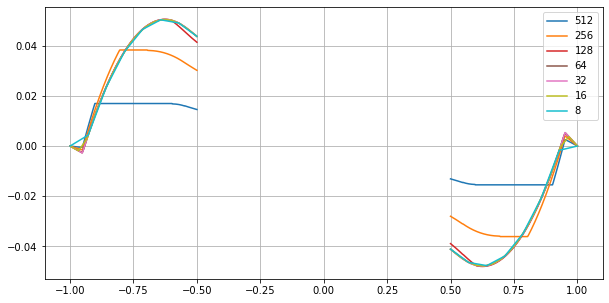

In [8]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

error_norm = []

for idx, nodes_num in enumerate(tqdm(nodes_num_grid)):
    model = SpringRodsSystemSetup(
        **setup,
        nodes_num=nodes_num
    )
    solver = SpringRodsSystemSolver(model)
    solution = solver(model)

    curr_domain = np.concatenate((model.domain[0], model.domain[1]))
    err = solution - approximate_in_positions(reference_solution, reference_domain, curr_domain)
    error_norm.append(l2_norm(values=err, nodes=curr_domain))

    plt.plot(model.domain[0], err[:model.domain[0].size], color=cmap(idx), label=f'{nodes_num_grid[idx]}')
    plt.plot(model.domain[1], err[model.domain[0].size:], color=cmap(idx))

plt.legend()

([<matplotlib.axis.YTick at 0x7f1fe826b7f0>,
 [Text(0, 1.5010043626064153e-06, '1.50e-06'),
  Text(0, 5.60884336611545e-06, '5.61e-06'),
  Text(0, 1.631771817787596e-05, '1.63e-05'),
  Text(0, 4.606677081293523e-05, '4.61e-05'),
  Text(0, 0.0001340177448670311, '1.34e-04'),
  Text(0, 0.0003776358037837002, '3.78e-04'),
  Text(0, 0.001122886736004714, '1.12e-03')])

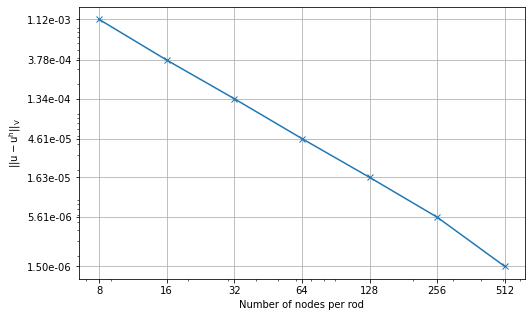

In [9]:
fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.plot(nodes_num_grid, error_norm, marker='x')
plt.xlabel('Number of nodes per rod')
plt.ylabel('$||u - u^h||_V$')
plt.xscale('log')
plt.yscale('log')
plt.xticks(nodes_num_grid, nodes_num_grid)
plt.yticks(error_norm, [f'{err:.2e}' for err in error_norm])